사이트에 있는 코드를 따라하며 공부를 해본다. 한 줄 한 줄 뜯어보며 해석하자.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [91]:
# dt_of_fr은 날짜로 해석하기 위해 parse_dates 옵션 추가
train = pd.read_csv('C:/develop/jupyter notebook/COMPAS/PJT002_train.csv', parse_dates=["dt_of_fr"])
val = pd.read_csv('C:/develop/jupyter notebook/COMPAS/PJT002_validation.csv', parse_dates=["dt_of_fr"])
test = pd.read_csv('C:/develop/jupyter notebook/COMPAS/PJT002_test.csv', parse_dates=["dt_of_fr"])
sub = pd.read_csv('C:/develop/jupyter notebook/COMPAS/PJT002_submission.csv')

In [42]:
train.isna().sum()

dt_of_fr                            0
fr_yn                               0
bldng_us                        27677
bldng_archtctr                  27665
bldng_cnt                           0
bldng_ar                            0
ttl_ar                              0
lnd_ar                              0
dt_of_athrztn                   27581
ttl_grnd_flr                    10210
ttl_dwn_flr                     11005
bldng_us_clssfctn               29343
tmprtr                             13
prcpttn                         53629
wnd_spd                            33
wnd_drctn                         221
hmdt                               22
gas_engry_us_201401             27581
ele_engry_us_201401             27581
gas_engry_us_201402             27581
ele_engry_us_201402             27581
gas_engry_us_201403             27581
ele_engry_us_201403             27581
gas_engry_us_201404             27581
ele_engry_us_201404             27581
gas_engry_us_201405             27581
ele_engry_us

In [43]:
train.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59199 entries, 0 to 59198
Data columns (total 180 columns):
dt_of_fr                        datetime64[ns]
fr_yn                           object
bldng_us                        object
bldng_archtctr                  object
bldng_cnt                       int64
bldng_ar                        float64
ttl_ar                          float64
lnd_ar                          float64
dt_of_athrztn                   object
ttl_grnd_flr                    float64
ttl_dwn_flr                     float64
bldng_us_clssfctn               object
tmprtr                          float64
prcpttn                         float64
wnd_spd                         float64
wnd_drctn                       float64
hmdt                            float64
gas_engry_us_201401             float64
ele_engry_us_201401             float64
gas_engry_us_201402             float64
ele_engry_us_201402             float64
gas_engry_us_201403             float64
ele_engry_

In [96]:
print(train['fr_yn'].head())
print()
print(val['fr_yn'].head())

0    Y
1    N
2    Y
3    N
4    N
Name: fr_yn, dtype: object

0    N
1    N
2    N
3    Y
4    N
Name: fr_yn, dtype: object


In [97]:
# binary로 변환
binary_y = {'N': 0, 'Y': 1}
train['fr_yn'] = train['fr_yn'].map(binary_y)
val['fr_yn'] = val['fr_yn'].map(binary_y)

In [98]:
print(train['fr_yn'].head())
print()
print(val['fr_yn'].head())

0    1
1    0
2    1
3    0
4    0
Name: fr_yn, dtype: int64

0    0
1    0
2    0
3    1
4    0
Name: fr_yn, dtype: int64


## Predict

### 모두 NO 로 예측하면?

In [99]:
y_pred = [0]*len(val) # validation 개수만큼 prediction의 결과값을 0(NO)으로 설정
y_val = val['fr_yn']

f1_score(y_val, y_pred)

0.0

## 모든 피처 다 넣기(시간 데이터 제외)

### Prepare dataset

In [100]:
X_train = train.drop(['fr_yn', 'dt_of_fr'], 1) # train에서 'fr_yn', 'dt_of_fr' column을 drop
y_train = train['fr_yn']
X_val = val.drop(['fr_yn', 'dt_of_fr'], 1) # val에서 'fr_yn', 'dt_of_fr' column을 drop
y_val = val['fr_yn']
test = test.drop(['dt_of_fr'], 1) # test에서 'dt_of_fr' column을 drop

In [101]:
 # X_train, X_val, test를 세로로 아래로 합치기
df_all = pd.concat([X_train, X_val, test])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [102]:
# 컬럼 data type 중 'object'인 것들만 추려내어 컬럼명으로 리스트 만들기
categorical_cols = df_all.select_dtypes(['object']).columns

In [103]:
categorical_cols

Index(['bldng_archtctr', 'bldng_us', 'bldng_us_clssfctn',
       'blk_dngrs_thng_mnfctr_yn', 'cltrl_hrtg_yn', 'dngrs_thng_yn',
       'dt_of_athrztn', 'emd_nm', 'fr_fghtng_fclt_spcl_css_5_yn',
       'fr_fghtng_fclt_spcl_css_6_yn', 'jmk', 'lnd_us_sttn_nm', 'mlt_us_yn',
       'rd_sd_nm', 'rgnl_ar_nm', 'rgnl_ar_nm2', 'slf_fr_brgd_yn', 'trgt_crtr',
       'us_yn'],
      dtype='object')

In [104]:
# data type이 'object'인 각 column을 돌며 value값들을 categorical variable로 변환
for col in categorical_cols:
    df_all[col] = pd.Categorical(df_all[col]).codes

In [105]:
# 다시 X_train, X_val, test로 잘라내기
X_train = df_all[:len(train)]
X_val = df_all[len(train):-len(test)]
test = df_all[-len(test):]

In [106]:
X_train = X_train.fillna(-1) # 결측치를 -1로 채우기
X_val = X_val.fillna(-1) # 결측치를 -1로 채우기
test = test.fillna(-1) # 결측치를 -1로 채우기

### train & predict

In [107]:
from  sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

f1_score(y_val, y_pred)

0.49501661129568103

### Feature importance

In [10]:
def plot_feature_importance(model, X_train, figsize=(12, 6)):
    sns.set_style('darkgrid')
    
    # Plot feature importance
    feature_importance = model.feature_importances_ # 각 feautre의 importance를 feature_importance라는 리스트에 담기
    feature_importance = 100.0 * (feature_importance / feature_importance.max()) # 상대적 중요도를 0-100으로 보여주기 위해 거치는 작업
    sorted_idx = np.argsort(feature_importance) # np.argsort : 작은값부터 순서대로 데이터의 index 반환
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=figsize)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

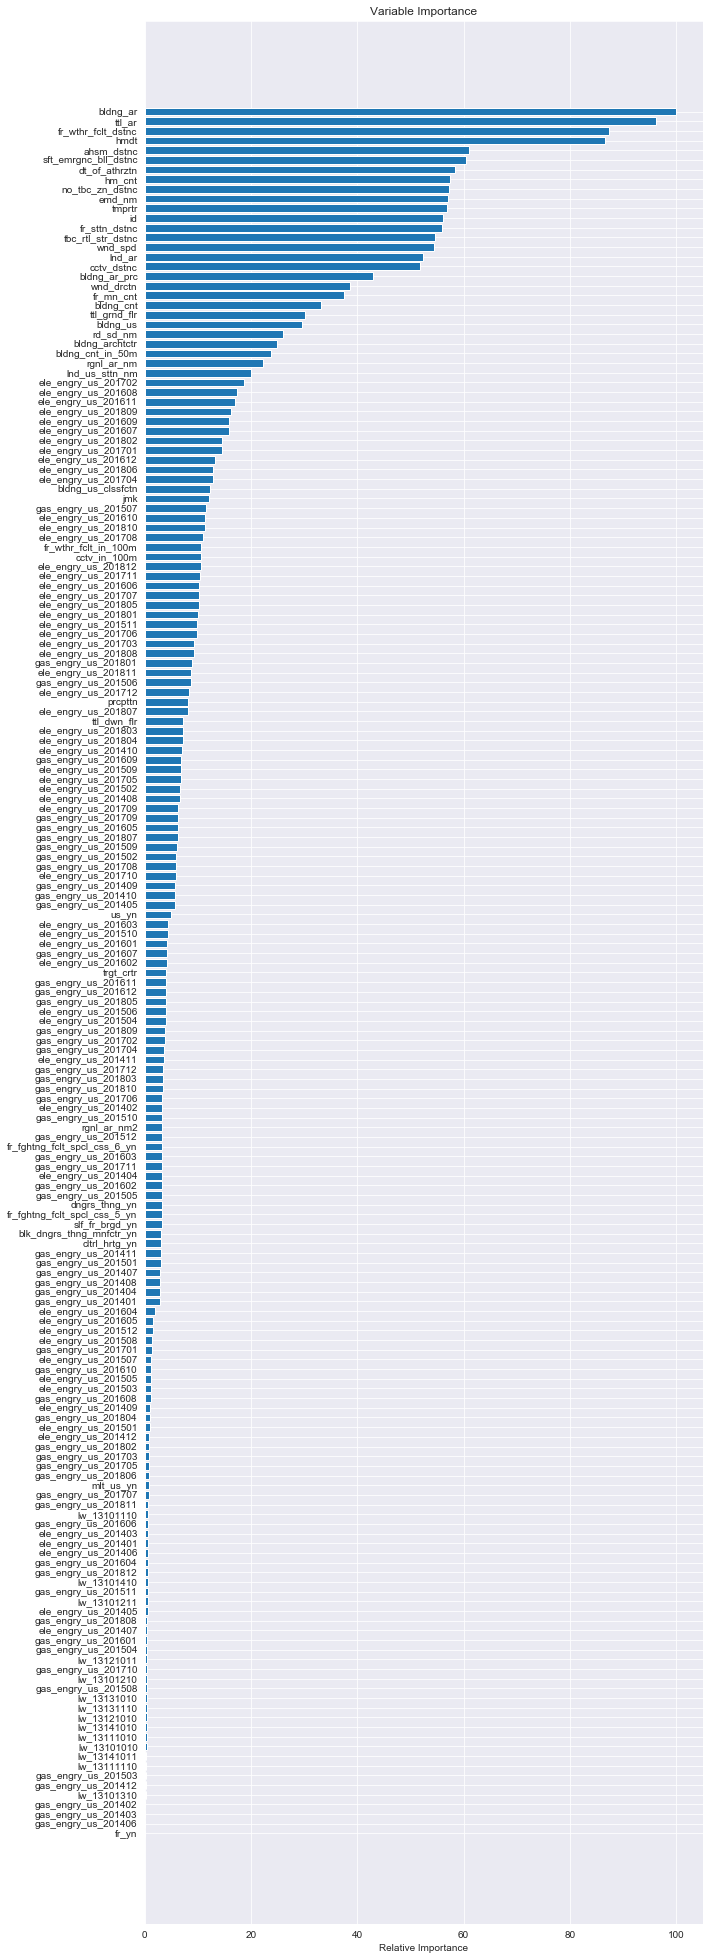

In [11]:
plot_feature_importance(model, X_train, (10, 35))

생각해본 것
1. relative importance가 높은 20위를 추려내어 변수로 삼아보기
2. relative importance가 20 미만인 것들을 제거한 후 남는 변수들을 사용해보기

## 1. relative importance가 높은 20위 추려내어 변수로 삼아보기


In [112]:
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-20:]

In [113]:
sorted_idx

array([ 77, 177,   2,   9, 146, 178, 170,  78, 144, 171,  74, 163, 142,
        13, 168,   0, 143,  79, 173,   1], dtype=int64)

In [121]:
# 상대적 중요도가 높은 20개의 column 명을 high20 이라는 리스트에 담기
high20 = []
for index in sorted_idx:
    high20.append(df_all.columns[index])
high20.reverse()
high20  

['bldng_ar',
 'ttl_ar',
 'fr_wthr_fclt_dstnc',
 'hmdt',
 'ahsm_dstnc',
 'sft_emrgnc_bll_dstnc',
 'dt_of_athrztn',
 'hm_cnt',
 'no_tbc_zn_dstnc',
 'emd_nm',
 'tmprtr',
 'id',
 'fr_sttn_dstnc',
 'tbc_rtl_str_dstnc',
 'wnd_spd',
 'lnd_ar',
 'cctv_dstnc',
 'bldng_ar_prc',
 'wnd_drctn',
 'fr_mn_cnt']

In [148]:
# X_train, X_val, test 세로로 병합
df_all = pd.concat([X_train, X_val, test])

In [149]:
# 상대적 중요도가 높은 20개의 컬럼만 추출하여 새로운 dataframe 생성
df_all = df_all[[x for x in high20]]

In [150]:
df_all

,bldng_ar,ttl_ar,fr_wthr_fclt_dstnc,hmdt,ahsm_dstnc,sft_emrgnc_bll_dstnc,dt_of_athrztn,hm_cnt,no_tbc_zn_dstnc,emd_nm,tmprtr,id,fr_sttn_dstnc,tbc_rtl_str_dstnc,wnd_spd,lnd_ar,cctv_dstnc,bldng_ar_prc,wnd_drctn,fr_mn_cnt
0,69.420,69.420,133,96.0,11322,29231,100,17360.0,88,199,10.7,106536,4547,1891,0.9,0.0,112,-1.0,200.0,137.0
1,46.290,46.290,489,74.0,3369,20480,-1,1791.0,7727,141,19.5,86366,6388,4533,0.5,0.0,818,122581.0,20.0,85.0
2,583.800,2516.760,143,21.0,12451,31197,7065,17285.0,72,199,15.5,107560,3340,277,2.0,1446.0,165,618105.0,90.0,137.0
3,48.920,48.920,1585,91.0,407,4270,59,7327.0,508,261,20.6,97550,179,438,0.4,0.0,131,719542.0,0.0,176.0
4,0.000,0.000,603,89.0,12487,29778,-1,17278.0,707,199,12.7,130501,4822,1702,0.6,0.0,686,-1.0,360.0,137.0
5,96.660,149.040,294,11.0,11690,29709,10712,17278.0,206,199,27.8,132645,4278,1425,4.5,486.0,210,899087.0,180.0,137.0
6,84.000,84.000,778,93.0,7676,29118,-1,17132.0,1609,199,20.9,80634,4387,3128,0.5,495.0,741,-1.0,360.0,137.0
7,92.000,92.040,310,78.0,13237,33829,5359,17302.0,695,199,5.8,83207,2008,1951,0.5,0.0,519,233594.0,200.0,137.0
8,102.360,102.360,1027,95.0,9565,30379,-1,17302.0,523,199,2.1,102921,2752,1201,0.8,0.0,521,-1.0,180.0,137.0
9,66.130,66.130,1326,89.0,10588,26904,70,17199.0,133,199,-2.8,73279,6587,3528,0.8,0.0,460,-1.0,70.0,137.0


In [151]:
# 다시 
X_train = df_all[:len(train)]
X_val = df_all[len(train):-len(test)]
test = df_all[-len(test):]

In [152]:
X_train = X_train.fillna(-1) # 결측치를 -1로 채우기
X_val = X_val.fillna(-1) # 결측치를 -1로 채우기
test = test.fillna(-1) # 결측치를 -1로 채우기

In [153]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

f1_score(y_val, y_pred)

0.49354712553773955

# 오히려 더 떨어졌다...

### Submission

In [12]:
y = model.predict(test)

In [13]:
sub['fr_yn'] = y
sub['fr_yn'] = sub['fr_yn'].map({0:'N', 1:'Y'})
sub.head()

,fr_yn
0,N
1,N
2,N
3,N
4,N


In [14]:
sub.to_csv('사이트따라해보기.csv', index=False)